In [1]:
import sys, os
sys.path.insert(0, "/home/storage/hans/jax_reco")
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import jax.numpy as jnp
from jax.scipy import optimize
import jax
jax.config.update("jax_enable_x64", True)

import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lib.simdata_i3 import I3SimHandlerFtr
from lib.geo import center_track_pos_and_time_based_on_data

In [2]:
# Get an IceCube event.
bp = '/home/storage2/hans/i3files/21217'
sim_handler = I3SimHandlerFtr(os.path.join(bp, 'meta_ds_21217_from_35000_to_53530.ftr'),
                              os.path.join(bp, 'pulses_ds_21217_from_35000_to_53530.ftr'),
                              '/home/storage/hans/jax_reco/data/icecube/detector_geometry.csv')


def get_event_data(event_index):
    meta, pulses = sim_handler.get_event_data(event_index)
    #print(f"muon energy: {meta['muon_energy_at_detector']/1.e3:.1f} TeV")

    # Get dom locations, first hit times, and total charges (for each dom).
    event_data = sim_handler.get_per_dom_summary_from_sim_data(meta, pulses)

    return (event_data[['x', 'y','z','time']].to_numpy(), 
            meta[['muon_energy_at_detector', 'q_tot', 'muon_zenith', 'muon_azimuth', 'muon_time',
                  'muon_pos_x', 'muon_pos_y', 'muon_pos_z', 'spline_mpe_zenith',
                  'spline_mpe_azimuth', 'spline_mpe_time', 'spline_mpe_pos_x',
                  'spline_mpe_pos_y', 'spline_mpe_pos_z']].to_numpy())

In [3]:
meta, pulses = sim_handler.get_event_data(0)
print(meta)

event_id                   2.121703e+09
idx_start                  0.000000e+00
idx_end                    4.600000e+01
n_channel_HLC              2.100000e+01
neutrino_energy            4.722192e+04
muon_energy                3.391497e+04
muon_energy_at_detector    2.139244e+03
muon_energy_lost           8.823812e+02
q_tot                      4.357500e+01
n_channel                  2.900000e+01
muon_zenith                2.201092e+00
muon_azimuth               4.044857e+00
muon_time                  3.002587e+03
muon_pos_x                -1.277511e+03
muon_pos_y                -1.390396e+03
muon_pos_z                -1.675980e+03
spline_mpe_zenith          2.224013e+00
spline_mpe_azimuth         4.035248e+00
spline_mpe_time            1.088498e+04
spline_mpe_pos_x          -9.655990e+01
spline_mpe_pos_y           1.078559e+02
spline_mpe_pos_z          -2.819733e+02
Name: 0, dtype: float64


In [4]:
_, meta = get_event_data(0)
print(meta)

[ 2.13924365e+03  4.35750000e+01  2.20109211e+00  4.04485650e+00
  3.00258667e+03 -1.27751129e+03 -1.39039565e+03 -1.67598025e+03
  2.22401345e+00  4.03524788e+00  1.08849820e+04 -9.65598967e+01
  1.07855873e+02 -2.81973256e+02]


In [5]:
pulse_data = []
meta_data = []
n_doms = []

for i in range(1000):
    ev, meta = get_event_data(i)
    pulse_data.append(ev)
    meta_data.append(meta)
    n_doms.append(ev.shape[0])

In [6]:
print(meta_data[1])

[ 2.01925366e+03  2.74200001e+02  2.28442419e+00  3.92640830e+00
  9.63442488e+03 -5.75877731e+01  1.04949606e+02 -4.59586996e+02
  2.29277311e+00  3.80837905e+00  9.91118734e+03 -1.49526274e+01
  1.51046642e+02 -4.04819476e+02]


346 13


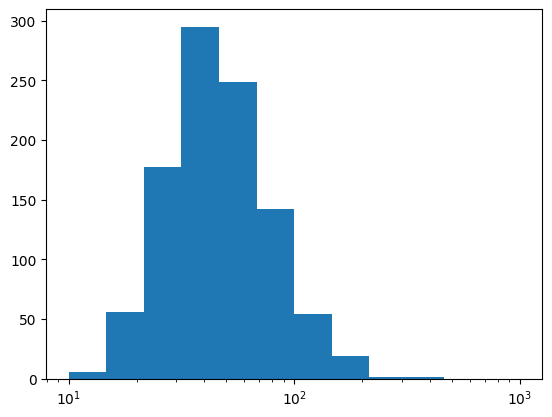

[  10.           12.58925412   15.84893192   19.95262315   25.11886432
   31.6227766    39.81071706   50.11872336   63.09573445   79.43282347
  100.          125.89254118  158.48931925  199.5262315   251.18864315
  316.22776602  398.10717055  501.18723363  630.95734448  794.32823472
 1000.        ]
[  6  56 177 295 249 142  54  19   1   1   0   0]
1000


In [7]:
print(max(n_doms), min(n_doms))

plt.hist(n_doms, bins=np.logspace(1, 3, 13))
plt.xscale('log')
plt.show()

print(np.logspace(1, 3, 21))
cts, bins = np.histogram(n_doms, bins=np.logspace(1, 3, 13))
print(cts)
print(sum(cts))

In [8]:
print(bins.astype(int))

[  10   14   21   31   46   68  100  146  215  316  464  681 1000]


In [9]:
pulse_data_tf = tf.ragged.constant(pulse_data, ragged_rank=1, dtype=tf.float32)

In [10]:
meta_data_tf = tf.constant(meta_data, dtype=tf.float32)

In [11]:
ds = tf.data.Dataset.from_tensor_slices((pulse_data_tf, meta_data_tf))
ds = ds.map(lambda x, y: (x, y))

_element_length_funct = lambda x, y: tf.shape(x)[0]
ds = ds.bucket_by_sequence_length(
            element_length_func = _element_length_funct,
            bucket_boundaries = np.logspace(1, 3, 13).astype(int).tolist(),
            bucket_batch_sizes = [128]*14,
            drop_remainder = False,
            pad_to_bucket_boundary=True
        )

In [12]:
for x, y in ds:
    print(x.shape, y.shape)

(128, 45, 4) (128, 14)
(128, 67, 4) (128, 14)
(128, 30, 4) (128, 14)
(128, 99, 4) (128, 14)
(128, 45, 4) (128, 14)
(2, 13, 4) (2, 14)
(50, 20, 4) (50, 14)
(41, 30, 4) (41, 14)
(45, 45, 4) (45, 14)
(123, 67, 4) (123, 14)
(24, 99, 4) (24, 14)
(53, 145, 4) (53, 14)
(20, 214, 4) (20, 14)
(1, 315, 4) (1, 14)
(1, 463, 4) (1, 14)


2024-06-05 19:33:56.843653: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [13]:
for x, y in ds:
    if x.shape[0]==128:
        break

In [14]:
for d in x:
    print(d.shape)

(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)


In [15]:
from lib.simdata_i3 import I3SimBatchHandler

In [16]:
batch_maker = I3SimBatchHandler(sim_handler)

In [17]:
batch_iter = batch_maker.get_batch_iterator()

In [18]:
a,b = batch_iter.next()

In [116]:
ev_idx = 2

In [117]:
fitting_event_data = jnp.array(a[ev_idx])
print(fitting_event_data.shape)

muon_truth = b[ev_idx, 2:8]
track_src = jnp.array(muon_truth[:2])
track_time = jnp.array(muon_truth[2])
track_pos = jnp.array(muon_truth[3:])
event_data = pd.DataFrame({'time': fitting_event_data[:, 3],
                           'charge': fitting_event_data[:, 4]
})

centered_track_pos, centered_track_time = \
    center_track_pos_and_time_based_on_data(event_data, track_pos, track_time, track_src)

fitting_event_data = fitting_event_data[:, :4]
print(jnp.rad2deg(track_src))
print(track_time)
print(track_pos)

(57, 5)
[117.61235437 201.11450864]
9512.693124104291
[-311.50606825 -237.85870606 -206.15769315]


In [118]:
print(centered_track_pos)
print(centered_track_time)

[152.80030886 -58.56269346  54.18189689]
11386.314582668698


In [119]:
print(fitting_event_data)

[[-2.9066e+02 -3.0738e+02 -1.4264e+02  1.0379e+04]
 [-2.9066e+02 -3.0738e+02 -1.5966e+02  1.0387e+04]
 [-2.9066e+02 -3.0738e+02 -2.7881e+02  1.1734e+04]
 [-3.6893e+02 -2.1023e+02 -1.2923e+02  1.0617e+04]
 [-3.6893e+02 -2.1023e+02 -1.8030e+02  9.9460e+03]
 [-3.6893e+02 -2.1023e+02 -1.9732e+02  1.0741e+04]
 [-3.6893e+02 -2.1023e+02 -2.3136e+02  1.0092e+04]
 [-3.6893e+02 -2.1023e+02 -2.4838e+02  1.0269e+04]
 [-2.4565e+02 -1.9049e+02 -1.4492e+02  9.9520e+03]
 [-2.4565e+02 -1.9049e+02 -1.6195e+02  9.8850e+03]
 [-2.4565e+02 -1.9049e+02 -1.7897e+02  9.8700e+03]
 [-2.4565e+02 -1.9049e+02 -1.9599e+02  9.9120e+03]
 [-2.4565e+02 -1.9049e+02 -2.1301e+02  9.9190e+03]
 [-1.2177e+02 -1.7103e+02 -9.3450e+01  1.0439e+04]
 [-1.2177e+02 -1.7103e+02 -1.1047e+02  1.0368e+04]
 [-1.2177e+02 -1.7103e+02 -1.2749e+02  1.0371e+04]
 [ 1.7100e+00 -1.5063e+02  5.4720e+01  1.1405e+04]
 [ 1.7100e+00 -1.5063e+02 -1.3370e+01  1.1061e+04]
 [ 1.7100e+00 -1.5063e+02 -6.4430e+01  1.0888e+04]
 [ 1.2497e+02 -1.3125e+02  3.40

In [120]:
fitting_event_data = fitting_event_data[:-14]

In [121]:
print(fitting_event_data)

[[-2.9066e+02 -3.0738e+02 -1.4264e+02  1.0379e+04]
 [-2.9066e+02 -3.0738e+02 -1.5966e+02  1.0387e+04]
 [-2.9066e+02 -3.0738e+02 -2.7881e+02  1.1734e+04]
 [-3.6893e+02 -2.1023e+02 -1.2923e+02  1.0617e+04]
 [-3.6893e+02 -2.1023e+02 -1.8030e+02  9.9460e+03]
 [-3.6893e+02 -2.1023e+02 -1.9732e+02  1.0741e+04]
 [-3.6893e+02 -2.1023e+02 -2.3136e+02  1.0092e+04]
 [-3.6893e+02 -2.1023e+02 -2.4838e+02  1.0269e+04]
 [-2.4565e+02 -1.9049e+02 -1.4492e+02  9.9520e+03]
 [-2.4565e+02 -1.9049e+02 -1.6195e+02  9.8850e+03]
 [-2.4565e+02 -1.9049e+02 -1.7897e+02  9.8700e+03]
 [-2.4565e+02 -1.9049e+02 -1.9599e+02  9.9120e+03]
 [-2.4565e+02 -1.9049e+02 -2.1301e+02  9.9190e+03]
 [-1.2177e+02 -1.7103e+02 -9.3450e+01  1.0439e+04]
 [-1.2177e+02 -1.7103e+02 -1.1047e+02  1.0368e+04]
 [-1.2177e+02 -1.7103e+02 -1.2749e+02  1.0371e+04]
 [ 1.7100e+00 -1.5063e+02  5.4720e+01  1.1405e+04]
 [ 1.7100e+00 -1.5063e+02 -1.3370e+01  1.1061e+04]
 [ 1.7100e+00 -1.5063e+02 -6.4430e+01  1.0888e+04]
 [ 1.2497e+02 -1.3125e+02  3.40

In [122]:
from lib.network import get_network_eval_v_fn
from dom_track_eval import get_eval_network_doms_and_track
from likelihood_spe import get_llh_and_grad_fs_for_iminuit_migrad
from likelihood_spe import get_llh_and_grad_fs_for_iminuit_migrad_profile
from likelihood_spe import get_neg_c_triple_gamma_llh

In [123]:
# Get network and eval logic.
eval_network_v = get_network_eval_v_fn(bpath='/home/storage/hans/jax_reco/data/network')
eval_network_doms_and_track = get_eval_network_doms_and_track(eval_network_v)

In [124]:
obj_fn, obj_grad = get_llh_and_grad_fs_for_iminuit_migrad(eval_network_doms_and_track)

# put the thing below into a for loop if you want to reconstruct many events (without jit-recompiling everything)
f_prime = lambda x: obj_fn(x, centered_track_time, fitting_event_data)
grad_prime = lambda x: obj_grad(x, centered_track_time, fitting_event_data)

In [125]:
from iminuit import Minuit

In [126]:
x0 = jnp.concatenate([track_src, centered_track_pos])
m = Minuit(f_prime, x0, grad=grad_prime)
m.errordef = Minuit.LIKELIHOOD
m.limits = ((0.0, np.pi), (0.0, 2.0 * np.pi), (-500.0, 500.0),  (-500.0, 500.0),  (-500.0, 500.0))
m.strategy = 2
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 542.8                      │        Nfcn = 157, Ngrad = 5         │
│ EDM = 8.53e-05 (Goal: 0.0001)    │            time = 4.6 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │  2.0554   │  0.0017   │            │            │    0    │ 3.14159 │       │
│ 1 │ x1   │  3.5071   │  0.0023   │            │            │    0    │ 6.28319 │       │
│ 2 │ x2   │   152.1   │    2.8    │            │            │  -500   │   500   │       │
│ 3 │ x3   │   -57.5   │    1.3    │            │            │  -500   │   500   │       │
│ 4 │ x4   │   53.1    │    0.7    │            │            │  -500   │   500   │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬────────────────────────────────────────────────────────┐
│    │         x0         x1         x2         x3         x4 │
├────┼────────────────────────────────────────────────────────┤
│ x0 │   3.06e-06     1.0e-6  4.4202e-3 -1.8073e-3   819.7e-6 │
│ x1 │     1.0e-6   5.33e-06   1.802e-3    -908e-6     463e-6 │
│ x2 │  4.4202e-3   1.802e-3       7.74       -3.3        1.7 │
│ x3 │ -1.8073e-3    -908e-6       -3.3       1.61       -0.7 │
│ x4 │   819.7e-6     463e-6        1.7       -0.7      0.435 │
└────┴────────────────────────────────────────────────────────┘

In [127]:
def run():
    m = Minuit(f_prime, x0, grad=grad_prime)
    m.errordef = Minuit.LIKELIHOOD
    m.limits = ((0.0, np.pi), (0.0, 2.0 * np.pi), (-500.0, 500.0),  (-500.0, 500.0),  (-500.0, 500.0))
    m.strategy = 1
    m.migrad()

%timeit run()

178 ms ± 562 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [128]:
print("... solution found.")
print(f"-2*logl={m.fval:.3f}")
print(f"zenith={m.values[0]:.3f}rad")
print(f"azimuth={m.values[1]:.3f}rad")
print(f"x={m.values[2]:.3f}m")
print(f"y={m.values[3]:.3f}m")
print(f"z={m.values[4]:.3f}m")
print(f"at fix time t={centered_track_time:.3f}ns")

... solution found.
-2*logl=542.788
zenith=2.055rad
azimuth=3.507rad
x=152.111m
y=-57.460m
z=53.148m
at fix time t=11386.315ns


In [129]:
print(track_src)

[2.05272282 3.51011035]


In [130]:
print(f_prime(x0))

545.2664483049243


In [131]:
neg_llh = get_neg_c_triple_gamma_llh(eval_network_doms_and_track)
scale1 = 10.0
scale2 = 10.0

@jax.jit
def neg_llh_5D(x, track_time, data):
    return neg_llh(x[:2]/scale2, x[2:]*scale1, track_time, data)

@jax.jit
def minimize_bfgs(x0, track_time, data):
    result = optimize.minimize(neg_llh_5D,
                                x0,
                                args=(track_time, data),
                                method="BFGS", 
                                options={'maxiter':50, 'gtol':1.e-3})
    
    return result.fun, result.x

x0 = jnp.concatenate([track_src*scale2, centered_track_pos/scale1])
best_logl, best_x = minimize_bfgs(x0, centered_track_time, fitting_event_data)

print("... solution found.")
print(f"-2*logl={best_logl:.3f}")
print(f"zenith={best_x[0]/scale2:.3f}rad")
print(f"azimuth={best_x[1]/scale2:.3f}rad")
print(f"x={best_x[2]*scale1:.3f}m")
print(f"y={best_x[3]*scale1:.3f}m")
print(f"z={best_x[4]*scale1:.3f}m")
print(f"at fix time t={centered_track_time:.3f}ns")

... solution found.
-2*logl=542.207
zenith=2.059rad
azimuth=3.507rad
x=151.706m
y=-57.338m
z=53.643m
at fix time t=11386.315ns


In [132]:
%timeit minimize_bfgs(x0, centered_track_time, fitting_event_data)

53.6 ms ± 82.7 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [133]:
@jax.jit
def minimize_bfgs(x0, track_time, data):
    result = optimize.minimize(neg_llh_5D,
                                x0,
                                args=(track_time, data),
                                method="BFGS", 
                                options={'maxiter':50, 'gtol':1.e-3})
    
    return result

In [134]:
result = minimize_bfgs(x0, centered_track_time, fitting_event_data)

In [135]:
print(result)

OptimizeResults(x=Array([20.59277648, 35.07255389, 15.17062953, -5.7338198 ,  5.36426011],      dtype=float64), success=Array(True, dtype=bool), status=Array(0, dtype=int64, weak_type=True), fun=Array(542.20749242, dtype=float64), jac=Array([ 1.40447775e-04, -2.83146884e-04,  5.25167443e-05, -2.78237327e-04,
       -1.08377070e-04], dtype=float64), hess_inv=Array([[ 1.78233263e-03, -2.19980502e-04, -8.85363377e-05,
         8.22873628e-04, -5.35409671e-05],
       [-2.19980502e-04,  6.36727660e-04,  7.22296732e-05,
        -4.83562460e-04,  8.52613118e-04],
       [-8.85363377e-05,  7.22296732e-05,  8.89250140e-03,
        -3.80000807e-03,  1.46370724e-03],
       [ 8.22873628e-04, -4.83562460e-04, -3.80000807e-03,
         4.17298162e-03, -3.03824144e-03],
       [-5.35409671e-05,  8.52613118e-04,  1.46370724e-03,
        -3.03824144e-03,  9.24062002e-03]], dtype=float64), nfev=Array(23, dtype=int64, weak_type=True), njev=Array(23, dtype=int64, weak_type=True), nit=Array(14, dtype=int

In [136]:
%timeit minimize_bfgs(x0, centered_track_time, fitting_event_data)

53.8 ms ± 103 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [137]:
x = jnp.array(-0.5)
y = jnp.where(x>0, 1.0, 0.0)

In [138]:
neg_llh = get_neg_c_triple_gamma_llh(eval_network_doms_and_track)
scale1 = 10.0

@jax.jit
def neg_llh_5D(x, track_time, data):
    return neg_llh(x[:2], x[2:]*scale1, track_time, data)

@jax.jit
def minimize_bfgs(x0, track_time, data):
    result = optimize.minimize(neg_llh_5D,
                                x0,
                                args=(track_time, data),
                                method="BFGS", 
                                options={'maxiter':50, 'gtol':1.e-3})
    
    return result.fun, result.x

x0 = jnp.concatenate([track_src, centered_track_pos/scale1])
best_logl, best_x = minimize_bfgs(x0, centered_track_time, fitting_event_data)

print("... solution found.")
print(f"-2*logl={best_logl:.3f}")
print(f"zenith={best_x[0]:.3f}rad")
print(f"azimuth={best_x[1]:.3f}rad")
print(f"x={best_x[2]*scale1:.3f}m")
print(f"y={best_x[3]*scale1:.3f}m")
print(f"z={best_x[4]*scale1:.3f}m")
print(f"at fix time t={centered_track_time:.3f}ns")

... solution found.
-2*logl=542.207
zenith=2.059rad
azimuth=3.507rad
x=151.706m
y=-57.338m
z=53.643m
at fix time t=11386.315ns


In [139]:
scale = 10

@jax.jit
def neg_llh_3D(x, track_dir, track_time, data):
    return neg_llh(track_dir, x*scale, track_time, data)

@jax.jit
def minimize_bfgs_profile(track_dir, x0, track_time, data):
    return optimize.minimize(neg_llh_3D,
                             x0/scale,
                             args=(track_dir,
                                   track_time,
                                   data),
                             method='BFGS',
                             options={'maxiter':50, 'gtol':1.e-5}).fun

In [140]:
minimize_bfgs_profile_v = jax.jit(jax.vmap(minimize_bfgs_profile, (0, None, None, None), 0))

In [141]:
x0 = centered_track_pos
minimize_bfgs_profile(track_src, x0, centered_track_time, fitting_event_data)

Array(544.24458213, dtype=float64)

In [142]:
%timeit minimize_bfgs_profile(track_src, x0, centered_track_time, fitting_event_data)

37.6 ms ± 106 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [143]:
minimize_bfgs_profile(track_src-0.03, x0, centered_track_time, fitting_event_data)

Array(576.27249728, dtype=float64)

In [144]:
%timeit minimize_bfgs_profile(track_src-0.03, x0, centered_track_time, fitting_event_data)

43.8 ms ± 142 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [145]:
minimize_bfgs_profile(track_src+0.03, x0, centered_track_time, fitting_event_data)

Array(586.92127487, dtype=float64)

In [146]:
%timeit minimize_bfgs_profile(track_src+0.03, x0, centered_track_time, fitting_event_data)

58.9 ms ± 88.9 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [147]:
dzen = 0.03
dazi = 0.03
n_eval = 20
zenith = jnp.linspace(track_src[0]-dzen, track_src[0]+dazi, n_eval)
azimuth = jnp.linspace(track_src[1]-dzen, track_src[1]+dazi, n_eval)
X, Y = jnp.meshgrid(zenith, azimuth)
init_dirs = jnp.column_stack([X.flatten(), Y.flatten()])

In [148]:
def get_grid():
    logls = []
    for current_dir in init_dirs:
        logls.append(minimize_bfgs_profile(current_dir, x0, centered_track_time, fitting_event_data))
    return logls

In [149]:
logls = get_grid()

In [150]:
#%timeit get_grid()

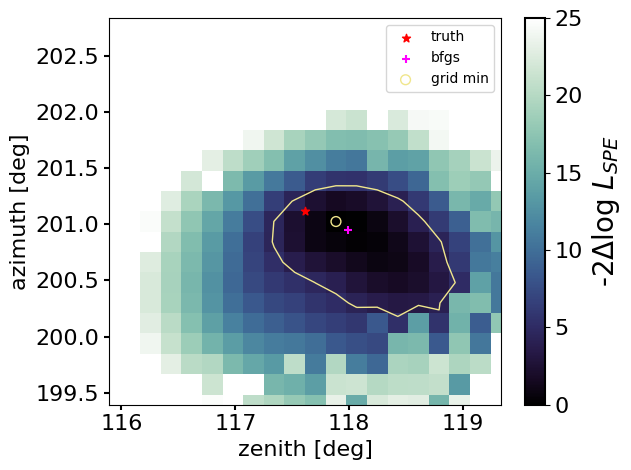

In [151]:
from palettable.cubehelix import Cubehelix
cx =Cubehelix.make(start=0.3, rotation=-0.5, n=16, reverse=False, gamma=1.0,
                           max_light=1.0,max_sat=0.5, min_sat=1.4).get_mpl_colormap()


logls = np.array(logls).reshape(X.shape)

fig, ax = plt.subplots()
min_logl = np.amin(logls)
delta_logl = logls - np.amin(logls)
pc = ax.pcolormesh(np.rad2deg(X), np.rad2deg(Y), delta_logl, vmin=0, vmax=np.min([25, 1.2*np.amax(delta_logl)]), shading='auto', cmap=cx)
cbar = fig.colorbar(pc)
cbar.ax.tick_params(labelsize=16)
cbar.ax.get_yaxis().labelpad = 5
cbar.set_label("-2$\\Delta$log $L_{SPE}$", fontsize=20)
cbar.outline.set_linewidth(1.5)

ax.set_xlabel("zenith [deg]", fontsize=16)
ax.set_ylabel("azimuth [deg]", fontsize=16)
ax.set_xlim(np.rad2deg([track_src[0]-dzen, track_src[0]+dzen]))
ax.set_ylim(np.rad2deg([track_src[1]-dazi, track_src[1]+dazi]))
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)

ax.scatter(np.rad2deg(track_src[0]), np.rad2deg(track_src[1]), marker="*", color='red', label="truth", zorder=200)

#smpe_zenith = meta['spline_mpe_zenith']
#smpe_azimuth = meta['spline_mpe_azimuth']
#ax.scatter(np.rad2deg([smpe_zenith]), np.rad2deg([smpe_azimuth]), marker="x", color='lime', label='splineMPE')

zenith = best_x[0]
azimuth = best_x[1]
ax.scatter(np.rad2deg(zenith), np.rad2deg(azimuth), marker='+', color='magenta', label='bfgs')

contours = [4.61]
ix1, ix2 = np.where(delta_logl==0)
ax.scatter(np.rad2deg([X[ix1, ix2]]), np.rad2deg([Y[ix1, ix2]]), s=50, marker='o', facecolors='none', edgecolors='khaki', zorder=100., label='grid min')
ct = plt.contour(np.rad2deg(X), np.rad2deg(Y), delta_logl, levels=contours, linestyles=['solid'], colors=['khaki'], linewidths=1.0)

plt.legend()
plt.tight_layout()
plt.show()

In [152]:
#minimize_bfgs_profile_v(init_dirs, x0, centered_track_time, fitting_event_data)

In [153]:
from likelihood_spe import get_llh_and_grad_fs_for_iminuit_migrad_profile

In [154]:
neg_llh_3D_m, neg_llh_3D_grad_m = get_llh_and_grad_fs_for_iminuit_migrad_profile(eval_network_doms_and_track)

In [155]:
def lets_profile(track_dir, obj_fn, obj_grad, vertex_seed, time, data):
    f_prime = lambda x: obj_fn(track_dir, x, time, data)
    grad_prime = lambda x: obj_grad(track_dir, x, time, data)

    x0 = jnp.array(vertex_seed)
    m = Minuit(f_prime, x0, grad=grad_prime)
    m.errordef = Minuit.LIKELIHOOD
    m.limits = ((-500.0, 500.0),  (-500.0, 500.0),  (-500.0, 500.0))
    m.strategy = 0
    m.migrad()
    return m.fval

In [156]:
logls = np.zeros(len(init_dirs))

for i, tdir in enumerate(init_dirs):
    logls[i] = lets_profile(tdir, neg_llh_3D_m, neg_llh_3D_grad_m,
            centered_track_pos,
            centered_track_time,
            fitting_event_data)

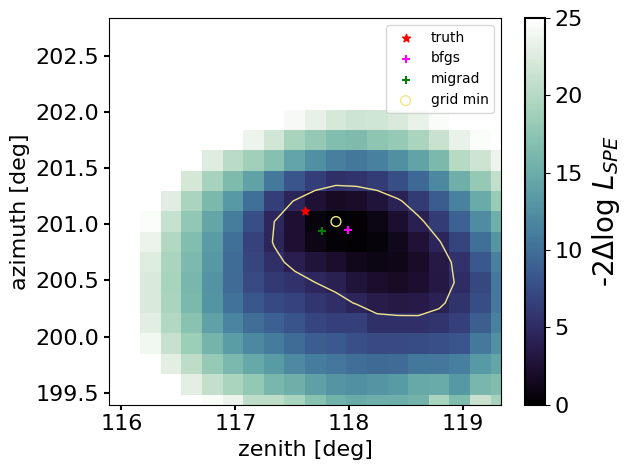

In [157]:
from palettable.cubehelix import Cubehelix
cx =Cubehelix.make(start=0.3, rotation=-0.5, n=16, reverse=False, gamma=1.0,
                           max_light=1.0,max_sat=0.5, min_sat=1.4).get_mpl_colormap()


logls = np.array(logls).reshape(X.shape)

fig, ax = plt.subplots()
min_logl = np.amin(logls)
delta_logl = logls - np.amin(logls)
pc = ax.pcolormesh(np.rad2deg(X), np.rad2deg(Y), delta_logl, vmin=0, vmax=np.min([25, 1.2*np.amax(delta_logl)]), shading='auto', cmap=cx)
cbar = fig.colorbar(pc)
cbar.ax.tick_params(labelsize=16)
cbar.ax.get_yaxis().labelpad = 5
cbar.set_label("-2$\\Delta$log $L_{SPE}$", fontsize=20)
cbar.outline.set_linewidth(1.5)

ax.set_xlabel("zenith [deg]", fontsize=16)
ax.set_ylabel("azimuth [deg]", fontsize=16)
ax.set_xlim(np.rad2deg([track_src[0]-dzen, track_src[0]+dzen]))
ax.set_ylim(np.rad2deg([track_src[1]-dazi, track_src[1]+dazi]))
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)

ax.scatter(np.rad2deg(track_src[0]), np.rad2deg(track_src[1]), marker="*", color='red', label="truth", zorder=200)

#smpe_zenith = meta['spline_mpe_zenith']
#smpe_azimuth = meta['spline_mpe_azimuth']
#ax.scatter(np.rad2deg([smpe_zenith]), np.rad2deg([smpe_azimuth]), marker="x", color='lime', label='splineMPE')

zenith = best_x[0]
azimuth = best_x[1]
ax.scatter(np.rad2deg(zenith), np.rad2deg(azimuth), marker='+', color='magenta', label='bfgs')

zenith = m.values[0]
azimuth = m.values[1]
ax.scatter(np.rad2deg(zenith), np.rad2deg(azimuth), marker='+', color='green', label='migrad')

contours = [4.61]
ix1, ix2 = np.where(delta_logl==0)
ax.scatter(np.rad2deg([X[ix1, ix2]]), np.rad2deg([Y[ix1, ix2]]), s=50, marker='o', facecolors='none', edgecolors='khaki', zorder=100., label='grid min')
ct = plt.contour(np.rad2deg(X), np.rad2deg(Y), delta_logl, levels=contours, linestyles=['solid'], colors=['khaki'], linewidths=1.0)

plt.legend()
plt.tight_layout()
plt.show()